# Lab 2

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gmm import GMM
import pandas as pd

# Exercice 1

In [2]:
N = 100 # Number of states

def generate_pdf(N):
    pi = np.random.rand(N)
    # pi = np.ones(N)
    pi /= pi.sum()
    return pi
cdf_pi = generate_pdf(N)

def generate_samples(N, pdf):
    cdf = np.cumsum(pdf)
    U = np.random.rand(N)
    for idx_u in range(len(U)):
        x = 0
        while x < len(cdf)-1 and U[idx_u] > cdf[x]:
            x += 1
        U[idx_u] = x
    return U

def plot_cdf(cdf, color):
    for k in range(len(cdf)):
        previous_value, value = cdf[k-1] if k>0 else 0, cdf[k] 
        plt.plot([k, k], [previous_value, value], color=color)
        plt.scatter(k, value, color=color)
        if k+1 < len(cdf):
            plt.plot([k, k+1], [value, value], color=color)

/var/folders/pb/_7l8b_td5_jfqdxkmrdd2gf40000gn/T/ipykernel_17782/3380172953.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


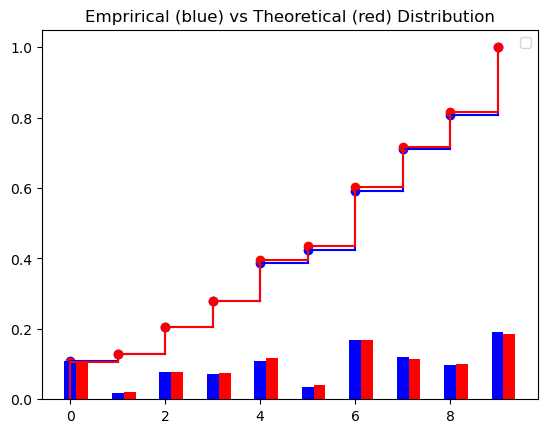

In [3]:
N = 10
pdf_pi = generate_pdf(N)
X = generate_samples(5_000, pdf_pi)

plt.figure()
plt.title(f"Emprirical (blue) vs Theoretical (red) Distribution")

# Plot the experimental distribution
cdf_exp = {int(key): (X <= key).sum()/len(X) for key in np.linspace(0, N-1, N)}
plot_cdf(cdf_exp, color="blue")

# Plot the theoretical distribution
plot_cdf(np.cumsum(pdf_pi), color="red")

for k in range(N):
    height = (X==k).mean()
    plt.bar(k, height, width=.25, color="blue")

    plt.bar(k+.25, pdf_pi[k], width=.25, color="red")

plt.legend()
plt.show()

In [4]:
plt.bar(X, )

TypeError: bar() missing 1 required positional argument: 'height'

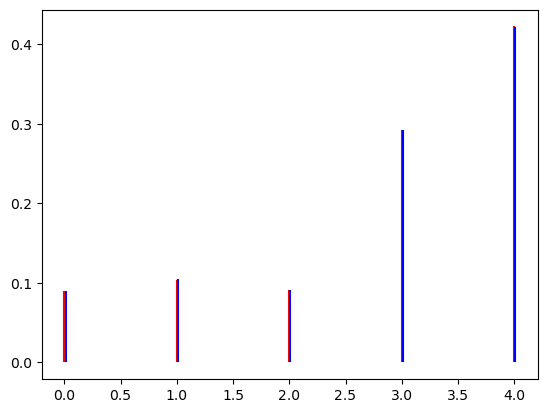

In [ ]:
plt.figure()

bar_dict = {key: (X == key).mean() for key in range(N)}

# plt.hist(X, density=True, bins=10)
for k in range(N):
    plt.vlines(k, 0, pdf_pi[k], color="red")
    plt.vlines(k+1e-2, 0, bar_dict[k], color="blue")

plt.show()

# Exercie 2

### Generate the data

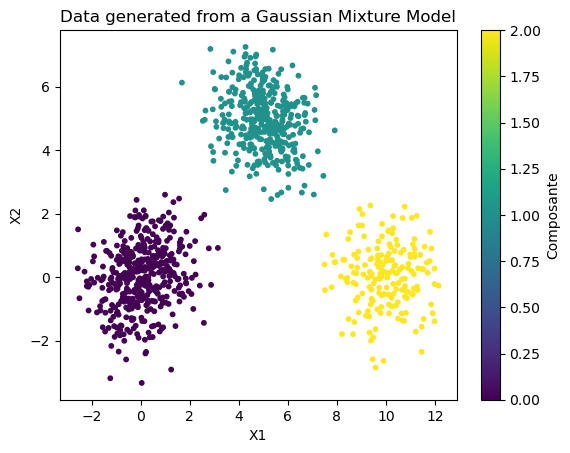

In [5]:
# Paramètres du modèle de mélange gaussien
M = 3  # Nombre de composantes du mélange
N = 1000  # Nombre d'échantillons

# Poids pour chaque composante (doit sommer à 1)
alphas = [0.45, 0.35, 0.25]

# Moyennes et matrices de covariance de chaque composante
means = np.array([np.array([0, 0]), np.array([5, 5]), np.array([10, 0])])
covariances = np.array([np.array([[1, 0.2], [0.2, 1]]), 
               np.array([[1, -0.3], [-0.3, 1]]), 
               np.array([[1, 0], [0, 1]])])

# Génération des données
X = np.zeros((N, 2))  # Tableau pour stocker les données
Z = generate_samples(N, pdf=alphas)  # Sélectionne les classes de chaque échantillon

for i in range(M):
    # Nombre d'échantillons pour la i-ème composante
    n_i = np.sum(Z == i)
    # Génération des échantillons gaussiens pour cette composante
    X[Z == i] = np.random.multivariate_normal(means[i], covariances[i], size=n_i)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=Z, cmap='viridis', s=10)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Data generated from a Gaussian Mixture Model")
plt.colorbar(label="Composante")
plt.show()


## Implement the GMM

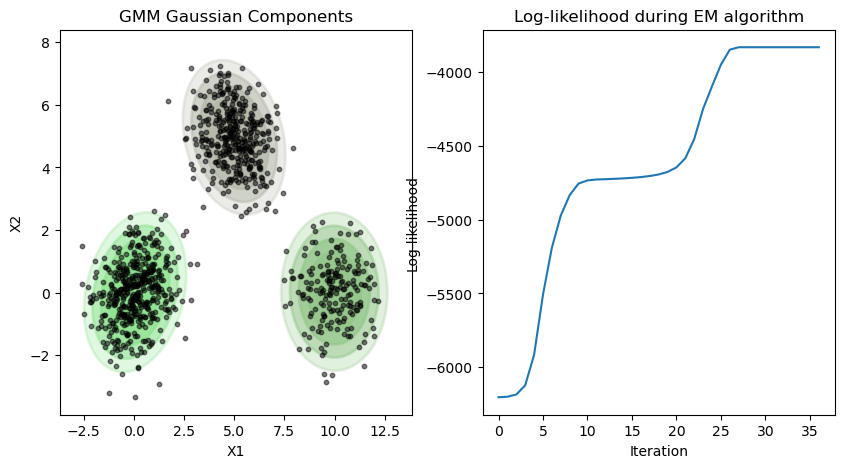

In [6]:
gmm = GMM(M=3, X=X, dim=2)
gmm.fit(max_iter=200, verbose=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

gmm.plot_gmm_ellipses(ax=ax[0])

ax[1].plot(gmm.log_likelihoods)
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Log-likelihood")
ax[1].set_title("Log-likelihood during EM algorithm")

plt.show()

## Implementation on real case study

/var/folders/pb/_7l8b_td5_jfqdxkmrdd2gf40000gn/T/ipykernel_17782/490354340.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Demo_data.csv")


<Axes: title={'center': 'Death Rate according to Birth Rate (year 1980)'}, xlabel='CBR', ylabel='CDR'>

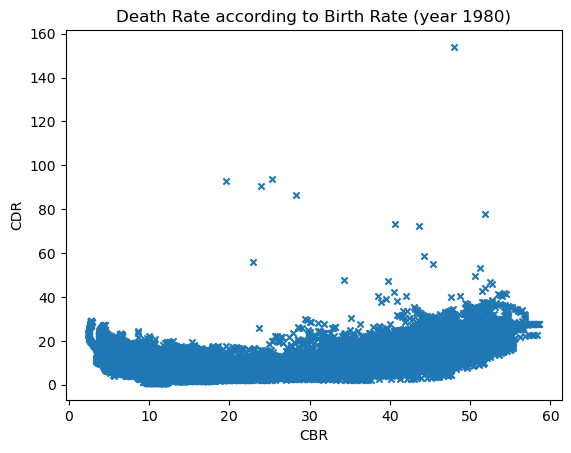

In [7]:
df = pd.read_csv("Demo_data.csv")
df = df[["CBR", "CDR"]].dropna(how='any', axis=0)
df.plot(kind="scatter", x="CBR", y="CDR", title="Death Rate according to Birth Rate (year 1980)" ,marker="x")

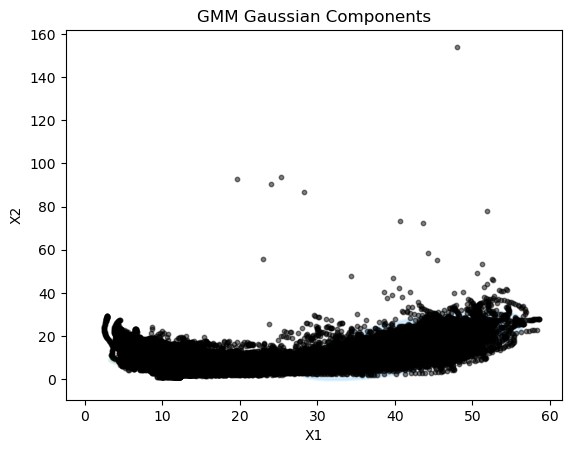

In [8]:
gmm = GMM(M=3, X=df.values, dim=2)
gmm.fit(max_iter=100, verbose=False)
gmm.plot_gmm_ellipses()

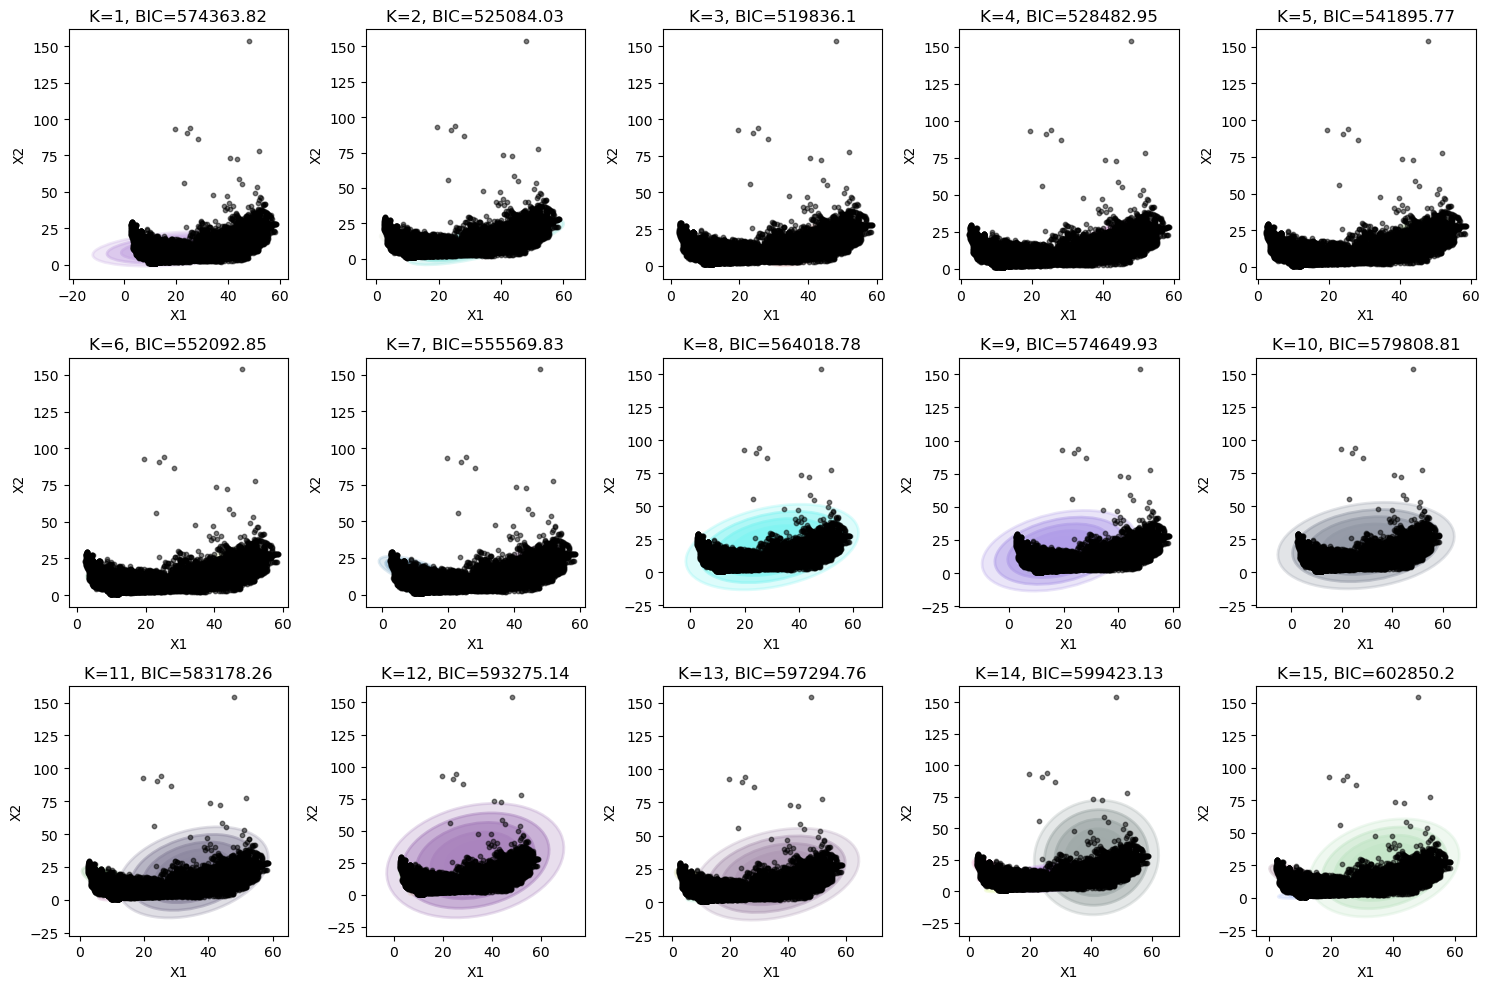

In [9]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for n_clusters in range(1, 16):
    plt.subplot(3, 5, n_clusters)
    gmm = GMM(M=n_clusters, X=df.values)
    gmm.fit(max_iter=50, verbose=False)
    gmm.plot_gmm_ellipses(ax=axes[(n_clusters-1)//5, (n_clusters-1)%5])
    plt.title(f"K={n_clusters}, BIC={round(gmm.bic(), 2)}")

plt.tight_layout()
plt.show()

# Exercise 3

## Question 1

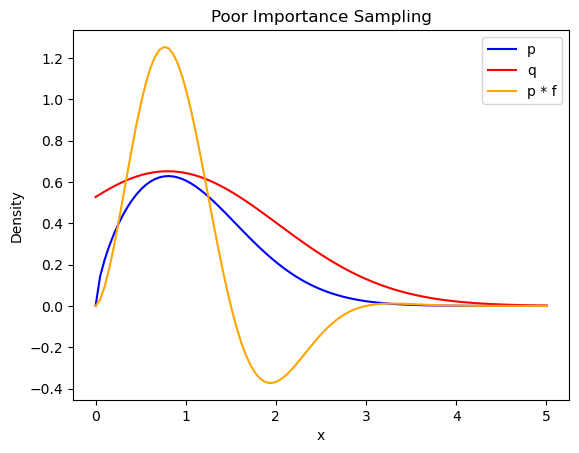

In [65]:
from tqdm import tqdm

p = lambda x: x ** (1.65-1) * np.exp(-x**2/2)
q = lambda x, mu: 2/np.sqrt(2*np.pi*1.5) * np.exp(-(mu-x)**2/(2*1.5))
f = lambda x: 2 * np.sin(np.pi/1.5*x)

def sample_q(N: int, mu:float=0.8) -> np.array:
    samples = np.random.normal(loc=mu, scale=1.5, size=N)
    while np.any(samples < 0):
        idx = (samples < 0)
        samples[idx] = np.random.normal(loc=mu, scale=1.5, size=idx.sum())
    return samples

def sample_w_tilde(X: np.array, mu:float = 0.8) -> np.array:
    return p(X) / q(X, mu)

def compute_sample_importance(f, N: int, mu:int = 0.8) -> float:
    X = sample_q(N, mu)
    w_tilde = sample_w_tilde(X, mu)
    w_tilde /= w_tilde.mean()
    return (w_tilde*f(X)), w_tilde

# compute_sample_importance(f, 100_000)

abscissa = np.linspace(0, 5, 100)
plt.title(f"Poor Importance Sampling")
plt.plot(abscissa, p(abscissa), label="p", color="blue")
plt.plot(abscissa, q(abscissa, mu=0.8), label="q", color="red")
plt.plot(abscissa, p(abscissa)*f(abscissa), label="p * f", color="orange")
plt.legend()
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

## Question 2

6it [00:00, 36.01it/s]


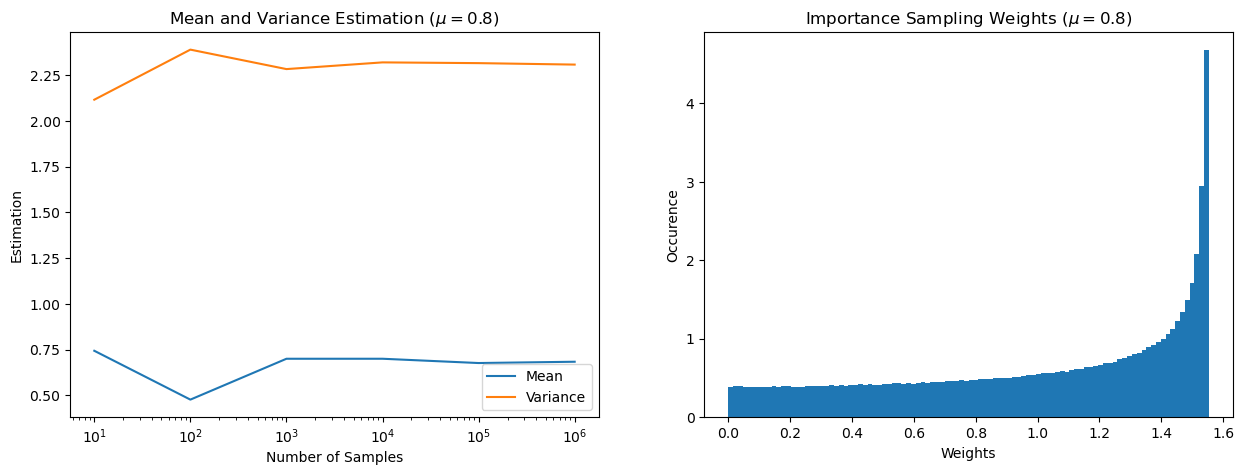

In [83]:
Ns = 10**np.arange(1, 7)
means = np.zeros(len(Ns))
var = np.zeros(len(Ns))
weights = []

for i, N in tqdm(enumerate(Ns)):
    N = int(N)
    distrib, weights_distrib = compute_sample_importance(f, N)
    means[i] = distrib.mean()
    var[i] = distrib.var()
    weights += list(weights_distrib)

plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title(r"Mean and Variance Estimation ($\mu=0.8$)")
plt.plot(Ns, means, label="Mean")
plt.plot(Ns, var, label="Variance")
plt.xlabel("Number of Samples")
plt.ylabel("Estimation")
plt.legend()
plt.xscale("log")

plt.subplot(1, 2, 2)
plt.title(r"Importance Sampling Weights ($\mu=0.8$)")
plt.hist(weights, bins=100, density=True)
plt.xlabel("Weights")
plt.ylabel("Occurence")
plt.show()

## Question 3

6it [00:00, 48.26it/s]


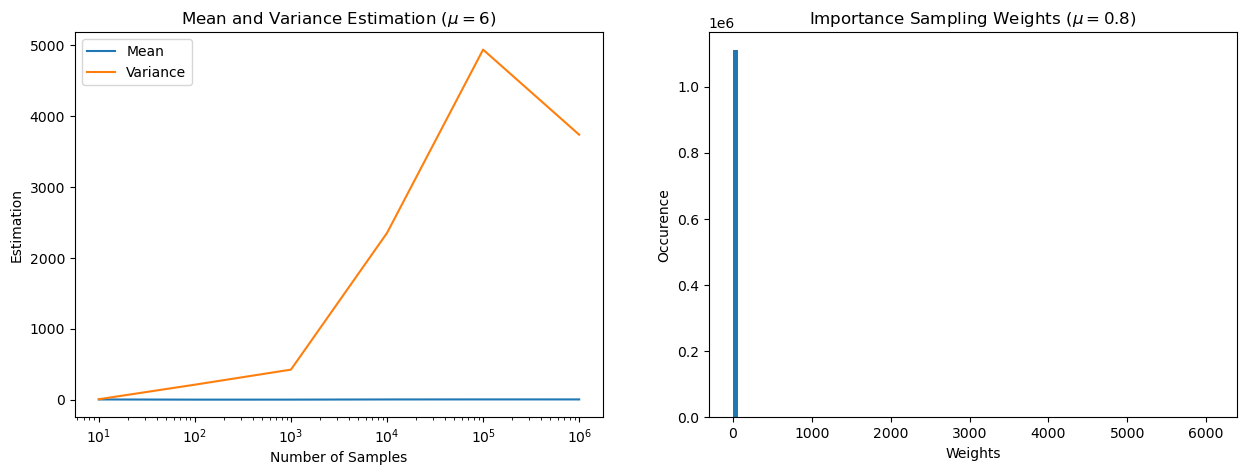

In [85]:
Ns = 10**np.arange(1, 7)
means = np.zeros(len(Ns))
var = np.zeros(len(Ns))
weights = []

for i, N in tqdm(enumerate(Ns)):
    N = int(N)
    distrib, weights_distrib = compute_sample_importance(f, N, 6)
    means[i] = distrib.mean()
    var[i] = distrib.var()
    weights += list(weights_distrib)

plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title(r"Mean and Variance Estimation ($\mu=6$)")
plt.plot(Ns, means, label="Mean")
plt.plot(Ns, var, label="Variance")
plt.xlabel("Number of Samples")
plt.ylabel("Estimation")
plt.legend()
plt.xscale("log")

plt.subplot(1, 2, 2)
plt.title(r"Importance Sampling Weights ($\mu=0.8$)")
plt.hist(weights, bins=100, density=False)
plt.xlabel("Weights")
plt.ylabel("Occurence")
plt.show()

## Question 5

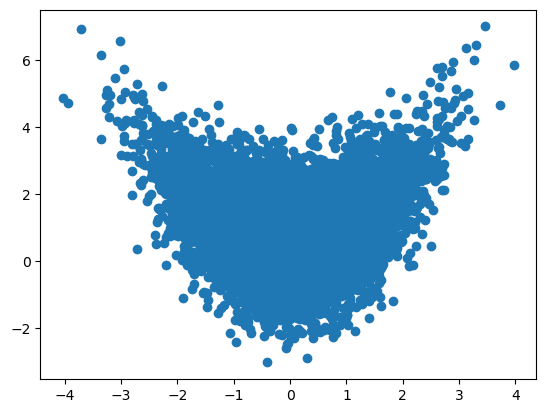

In [9]:
def generate_samples_nu(N: int) -> np.array:
    samples = np.random.multivariate_normal(mean=np.arange(5), cov=np.eye(5), size=N)
    samples[:, 1] += 0.4 * (samples[:, 0] ** 2 -1)
    return samples

X_banana = generate_samples_nu(10000)

plt.scatter(X_banana[:, 0], X_banana[:, 1])

In [10]:
def generate_samples_q(X_banana, N: int, nb_clusters: int) -> np.array:
    gmm = GMM(M=nb_clusters, X=X_banana, dim=5)
    gmm.fit(max_iter=100, verbose=False)

    samples_banana = np.zeros((N, 5))
    for idx in range(N):
        # Choose a cluster according to the weights pi
        cluster = np.random.choice(nb_clusters, p=gmm.pi)

        # Samples according this cluster
        sample = np.random.multivariate_normal(mean=gmm.mu[cluster], cov=gmm.sigma[cluster])
        
        samples_banana[idx] = sample

    return samples_banana


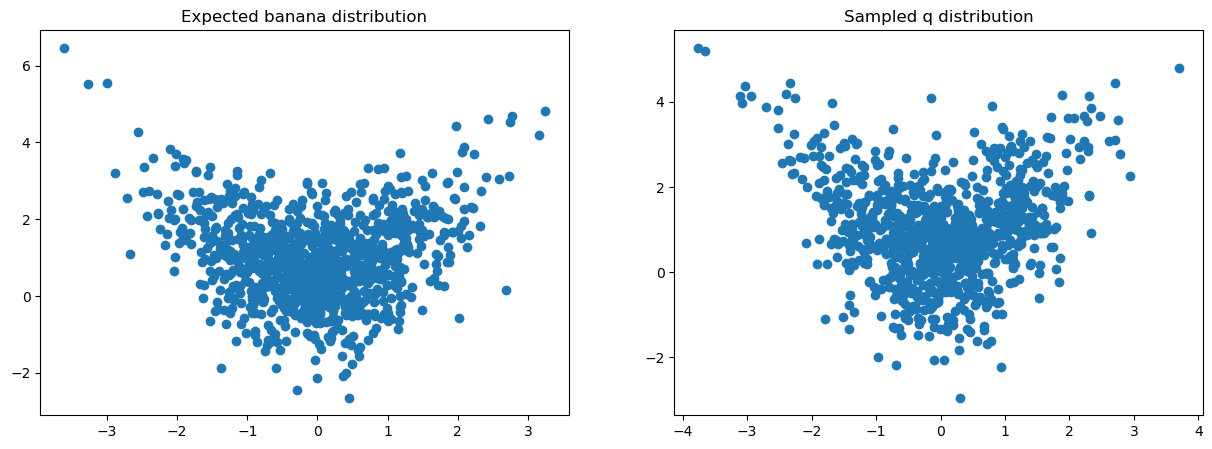

In [11]:
X_banana = generate_samples_nu(1000)
samples_banana = generate_samples_q(X_banana, 1000, 15)

plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Expected banana distribution")
plt.scatter(X_banana[:, 0], X_banana[:, 1])

plt.subplot(1, 2, 2)
plt.title("Sampled q distribution")
plt.scatter(samples_banana[:, 0], samples_banana[:, 1])

plt.show()

In [235]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

class Importance_Sampling:
    def __init__(self, N, M, dim):
        self.N       = N
        self.M       = M  
        self.dim     = dim
        self.alpha   = np.random.rand(M)
        self.alpha  /= self.alpha.sum()
        self.mu      = np.random.randint(-10, 10, size=(self.M, self.dim))
        self.tau     = np.zeros((self.N, self.M))
        self.pi      = np.ones(self.M) / self.M
        self.sigma   = np.array([np.eye(self.dim) for _ in range(self.M)])
        self.X       = np.zeros((self.N, self.dim))


    def _banana_distribution(self):
        X = self.X.copy()
        X[:, 1] -= 0.4 * (X[:, 0] ** 2 -1)
        return multivariate_normal(mean=np.zeros(5), cov=np.eye(5)).pdf(X)
    

    def _sample_X(self):
        for k in range(self.N):
            # Choose a cluster according to the weights pi
            cluster = generate_samples(1, self.alpha)[0]
            cluster = int(generate_samples(1, self.alpha)[0])

            # Samples according this cluster
            self.X[k] =  np.random.multivariate_normal(mean=self.mu[cluster], cov=self.sigma[cluster])
            
        return self.X
    

    def _compute_q(self):
        q = np.zeros(self.N)
        for k in range(self.M):
            q += self.alpha[k] * multivariate_normal(mean=self.mu[k], cov=self.sigma[k]+1e-9*np.eye(self.dim)).pdf(self.X)
        return q


    def _compute_importance_weights(self):
        weights = self._banana_distribution() / (self._compute_q() + 1e-9)
        return weights
    

    def _compute_importance_weights_normalized(self):
        weights = self._compute_importance_weights()
        self.weights_normalized = weights / weights.mean()
        return self.weights_normalized
        

    def _E_step(self):
        for k in range(self.M):
            self.tau[:, k] = self.alpha[k] * multivariate_normal(mean=self.mu[k], cov=self.sigma[k]+(1e-9)*np.eye(self.dim)).pdf(self.X)
        self.tau /= self.tau.sum(axis=1, keepdims=True) + 1e-9
        self.tau *= self.weights_normalized[:, None]


    def _update_alpha(self):
        self.alpha = self.tau.mean(axis=0)

    
    def _update_mu(self):
        self.mu = (self.tau.T @ self.X) / self.tau.sum(axis=0)[:, None] 

    
    def _update_sigma(self):
        for k in range(self.M):
            self.sigma[k] = (self.tau[:, k, None] * (self.X - self.mu[k])).T @ (self.X - self.mu[k]) / self.tau[:, k].sum()
            self.sigma[k] += np.eye(self.dim) * 1e-12


    def _M_step(self):
        self._update_alpha()
        self._update_mu()
        self._update_sigma()


    def fit(self, max_iter=100):
        kmeans = KMeans(n_clusters=self.M)
        self.X = generate_samples_nu(self.N)
        kmeans.fit(self.X)

        self.mu = kmeans.cluster_centers_
        self.sigma = np.array([np.cov(self.X[kmeans.labels_ == k].T) for k in range(self.M)])
        self.alpha = np.array([np.mean(kmeans.labels_ == k) for k in range(self.M)])
        for _ in tqdm(range(max_iter)):
            self._sample_X()
            self._compute_importance_weights_normalized()
            for _ in range(1):
                self._E_step()
                self._M_step()
        self._sample_X()
        
        return self.alpha, self.mu, self.sigma  
    

    def _plot_gaussian_ellipses(self, mu, sigma, ax=None, n_std=2.0, **kwargs):
        """
        Plot Gaussian confidence ellipses for a 2D GMM component.
        
        Parameters:
        -----------
        mu : numpy.ndarray
            Mean of the Gaussian (center of the ellipse), shape (2,).
        sigma : numpy.ndarray
            Covariance matrix of the Gaussian, shape (2, 2).
        ax : matplotlib.axes.Axes, optional
            The plot to draw the ellipses on (default is None, will create a new one).
        n_std : float, optional
            Number of standard deviations to determine the size of the ellipse (default is 2, for 95% confidence).
        kwargs : optional
            Additional keyword arguments for the Ellipse patch (like edgecolor, linestyle).
        
        Returns:
        --------
        matplotlib.patches.Ellipse
            The drawn ellipse object.
        """
        # Ensure that we are plotting in a 2D space
        if sigma.shape != (2, 2):
            raise ValueError("Sigma must be a 2x2 matrix.")
        
        # Eigenvalue decomposition of the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(sigma)
        
        # Get the angle of the largest eigenvector
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        
        # Width and height of the ellipse are 2 * sqrt(eigenvalues) * n_std
        width, height = 2 * n_std * np.sqrt(eigvals)
        
        # Create the ellipse
        radius_iter = 8
        for r in np.linspace(0, 1.5, radius_iter):
            ellipse = Ellipse(xy=mu, width=r*width, height=r*height, angle=angle, alpha=(1-(r/1.5)**2), **kwargs)
            
            if ax is None:
                ax = plt.gca()
            
            # Add the ellipse to the plot
            ax.add_patch(ellipse)
        
        return ellipse


    def plot_gmm_ellipses(self, ax=None, colors=None):
        """
        Plot ellipses for all components of a GMM.
        
        Parameters:
        -----------
        gmm : GMM object
            The GMM object containing mu and sigma.
        ax : matplotlib.axes.Axes, optional
            The plot to draw the ellipses on (default is None, will create a new one).
        """
        if ax is None:
            fig, ax = plt.subplots()


        # Plot data points as well
        ax.scatter(self.X[:, 0], self.X[:, 1], s=10, c='black', alpha=0.5)
        

        # Plot ellipses for each Gaussian component
        if colors is None:
            colors = np.random.random(size=(self.M, 3)) 
            colors = np.where(colors < 0.5, 1-colors, colors)  # Avoid very dark colors
        for k in range(self.M):
            self._plot_gaussian_ellipses(self.mu[k, :2], self.sigma[k, :2, :2], ax=ax, lw=2, n_std=2, edgecolor=colors[k], facecolor=colors[k])


        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_title('GMM Gaussian Components')



100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


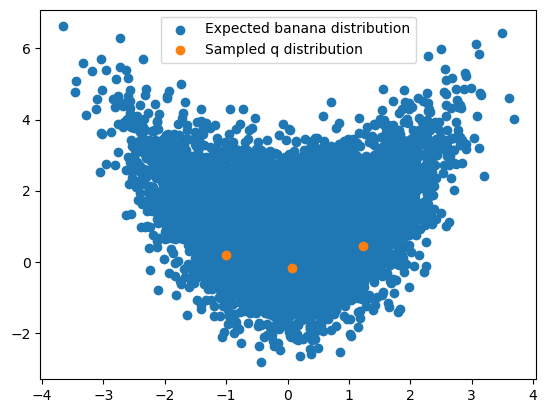

In [236]:
nb_clusters = 3

X_banana = generate_samples_nu(10_000)

q = Importance_Sampling(10_000, nb_clusters, 5)
q.fit()

samples_banana = np.array([q.alpha[k] * np.random.multivariate_normal(mean=q.mu[k], cov=q.sigma[k], size=100_000) for k in range(nb_clusters)])
samples_banana = samples_banana.sum(axis=0)

plt.figure()
plt.scatter(X_banana[:, 0], X_banana[:, 1], label="Expected banana distribution")
plt.scatter(q.mu[:, 0], q.mu[:, 1], label="Sampled q distribution")
plt.legend()
plt.show()

/var/folders/pb/_7l8b_td5_jfqdxkmrdd2gf40000gn/T/ipykernel_12703/413106947.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


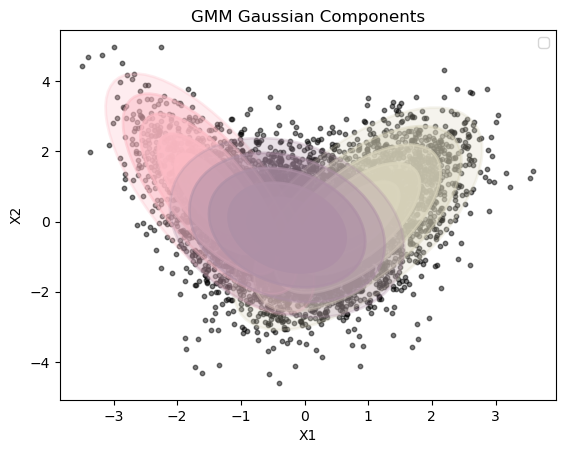

In [231]:
fig, ax = plt.subplots()

# ax.scatter(X_banana[:, 0], X_banana[:, 1], label="Sampled q distribution", alpha=0.5)
q.plot_gmm_ellipses(ax=ax)
ax.legend()
plt.show()

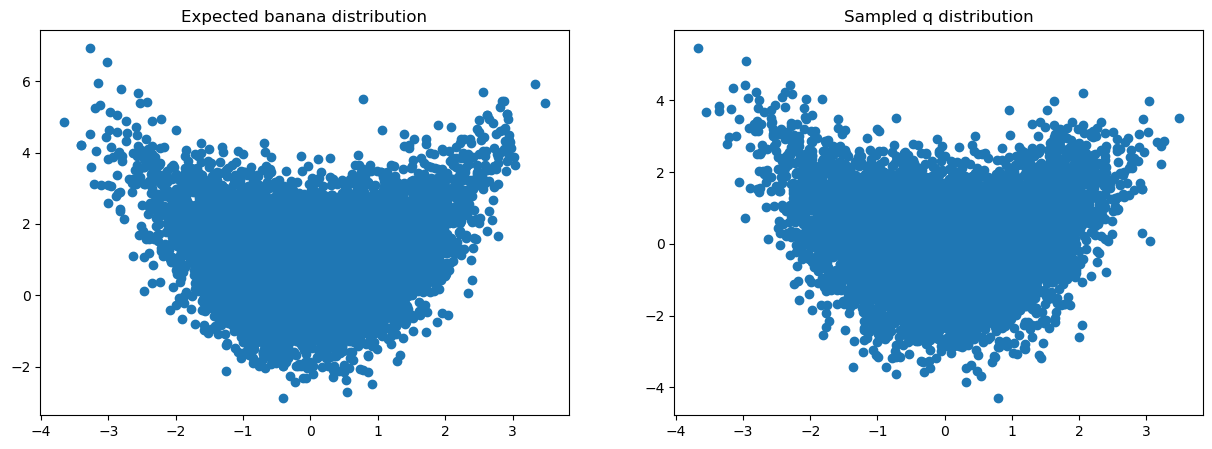

In [232]:
X_banana = generate_samples_nu(10_000)
samples_banana = q._sample_X()

plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Expected banana distribution")
plt.scatter(X_banana[:, 0], X_banana[:, 1])

plt.subplot(1, 2, 2)
plt.title("Sampled q distribution")
plt.scatter(samples_banana[:, 0], samples_banana[:, 1])

plt.show()